## Comparing KGs to real-world complex networks

Using a portion of *DBpedia* as target KG

# Environment Setup

Install & imports

In [ ]:
# Install required packages
import sys
!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

# Imports
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.7 MB/s eta 0:00:00


Auxiliary functions

In [ ]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))

    Ref.: https://stackoverflow.com/a/62662992
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

## Loading RDF model

Pointing to a remote Turtle (*.ttl) file.

In [ ]:
rg = RDFGraph()
rg.parse('https://dbpedia.org/data/Movie.ttl', format='ttl') # Turtle format

print("rdflib Graph loaded successfully with {} triples".format(len(rg)))

rdflib Graph loaded successfully with 3460 triples


## Converting rdflib.Graph to networkx.MultiDiGraph

KGs are directed graphs with the possibility of multiple paralell edges.

In [ ]:
# Conversion of rdflib.Graph to networkx.MultiDiGraph
KG = rdflib_to_networkx_multidigraph(rg)
print("networkx Graph loaded successfully with length {}".format(len(KG)))

networkx Graph loaded successfully with length 3411


# General Network Metrics

Network size and density

In [ ]:
# Network size
print("NETWORK SIZE")
print("============")
print("The network has {} nodes and {} edges".format(KG.number_of_nodes(), KG.number_of_edges()))
print()

# Density
print("DENSITY")
print("============")
print("The network density is {}".format(nx.density(KG)))
print()

NETWORK SIZE
The network has 3411 nodes and 3460 edges

DENSITY
The network density is 0.00029746782661924375



# Scale-free Networks

{In, Out}-degree distribution -- Is it Poisson's or Power-law alike?

Text(0, 0.5, 'Frequency')

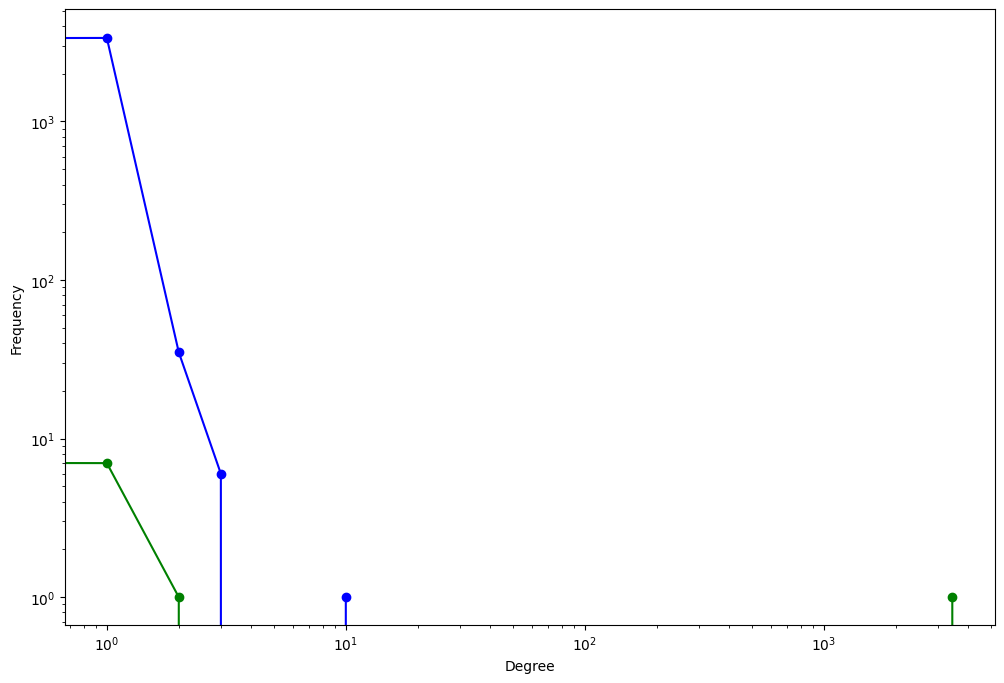

In [ ]:
in_degree_freq = degree_histogram_directed(KG, in_degree=True)
out_degree_freq = degree_histogram_directed(KG, out_degree=True)
degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8))
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'go-', label='in-degree')
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')

Are there HUBS available?

In [ ]:
h, a = nx.hits(KG)

print("Hubs:")
print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
print("")
print("Authorities:")
print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))

Hubs:
[(rdflib.term.URIRef('http://dbpedia.org/resource/Jacso_Group'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Sunset_Gower_Studios'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Centropolis_Entertainment'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/DViant_Films'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Pece_Trajkovski_–_Brada'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Ten_Thirty-One_Pictures_Entertainment'), 0.0008693124611183997), (rdflib.term.URIRef('http://dbpedia.org/resource/Hothat_Brishti'), 0.0005795416407455997), (rdflib.term.URIRef('http://dbpedia.org/resource/Hiripoda_Wassa'), 0.0005795416407455997), (rdflib.term.URIRef('http://dbpedia.org/resource/Melina_Petriella'), 0.0005795416407455997), (rdflib.term.URIRef('http://dbpedia.org/resource/Ami_Yamato'), 0.0005795416407455997), (rdflib.term.URIRef('http://dbpedia.org/r

# Communities

Check for communities using the Clauset-Newman-Moore Algorithm (greedy modularity - applicable to directed graphs)

In [ ]:
comms = nx.community.greedy_modularity_communities(KG)

print(f'Found {len(comms)} communities.')
idx = 0
for i in comms:
    print(f'Community {idx} has {len(i)} nodes.')
    #print(i)
    idx = idx + 1

Found 3403 communities.
Community 0 has 9 nodes.
Community 1 has 1 nodes.
Community 2 has 1 nodes.
Community 3 has 1 nodes.
Community 4 has 1 nodes.
Community 5 has 1 nodes.
Community 6 has 1 nodes.
Community 7 has 1 nodes.
Community 8 has 1 nodes.
Community 9 has 1 nodes.
Community 10 has 1 nodes.
Community 11 has 1 nodes.
Community 12 has 1 nodes.
Community 13 has 1 nodes.
Community 14 has 1 nodes.
Community 15 has 1 nodes.
Community 16 has 1 nodes.
Community 17 has 1 nodes.
Community 18 has 1 nodes.
Community 19 has 1 nodes.
Community 20 has 1 nodes.
Community 21 has 1 nodes.
Community 22 has 1 nodes.
Community 23 has 1 nodes.
Community 24 has 1 nodes.
Community 25 has 1 nodes.
Community 26 has 1 nodes.
Community 27 has 1 nodes.
Community 28 has 1 nodes.
Community 29 has 1 nodes.
Community 30 has 1 nodes.
Community 31 has 1 nodes.
Community 32 has 1 nodes.
Community 33 has 1 nodes.
Community 34 has 1 nodes.
Community 35 has 1 nodes.
Community 36 has 1 nodes.
Community 37 has 1 nodes

# Small-world networks

Does it have a low average shortest path?

In [ ]:
if nx.is_strongly_connected(KG):
    print(f'Average shortest path length: {nx.average_shortest_path_length(KG)}')
else:
    print('KG is NOT strongly connected!')

KG is NOT strongly connected!


Does it have a high clustering coefficient?

In [ ]:
# create weighted graph from M, as method is not implemented for MultiDiGraphs
DG = nx.DiGraph()
for u,v in KG.edges():
    if DG.has_edge(u,v):
        DG[u][v]['weight'] += 1
    else:
        DG.add_edge(u, v, weight=1)

ccs = nx.clustering(DG,weight='weight').values()

print(f"Clustering coefficient: {sum(ccs)/len(ccs)}")

Clustering coefficient: 0.0


# Some Centrality Measurements

DEGREE CENTRALITY
The mean degree centrality is 0.0005949356532384491, with stdev 0.01737321324851645
The maximum node is http://dbpedia.org/resource/Movie, with value 1.0149560117302052
The minimum node is http://dbpedia.org/resource/Will:_G._Gordon_Liddy, with value 0.0002932551319648094
(1.0149560117302052, 0.0008797653958944282, 0.0005865102639296188, 0.0002932551319648094) (1, 6, 37, 3367)


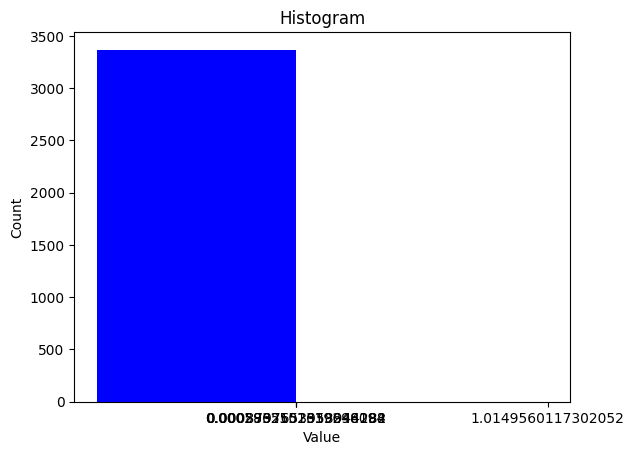


PAGERANK
The mean network pagerank is 0.0002931691586044716, with stdev 0.006438348855769621
The maximum node is http://dbpedia.org/resource/Movie, with value 0.3621245843252468
The minimum node is http://dbpedia.org/resource/Will:_G._Gordon_Liddy, with value 0.00010584961486130468
(0.3621245843252468, 0.061645456058786414, 0.030875652836823864, 0.00010584961486130468) (1, 1, 7, 3402)


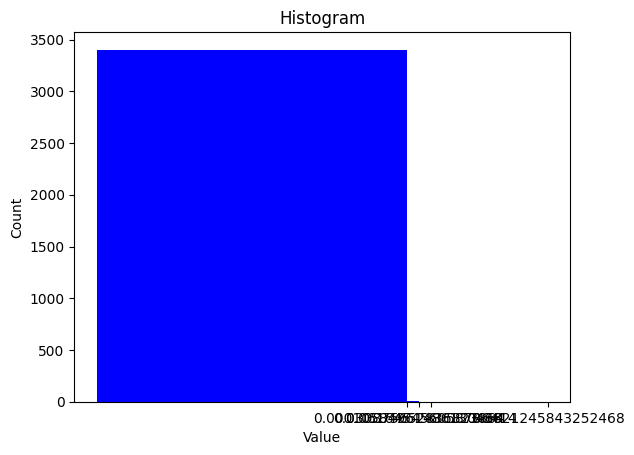


BETWEENNESS CENTRALITY
The mean betwenness centrality is 6.865511256378197e-07, with stdev 4.009717197657155e-05
The maximum node is http://dbpedia.org/resource/Movie, with value 0.002341825889550603
The minimum node is http://dbpedia.org/resource/Will:_G._Gordon_Liddy, with value 0.0
(0.002341825889550603, 0.0) (1, 3410)


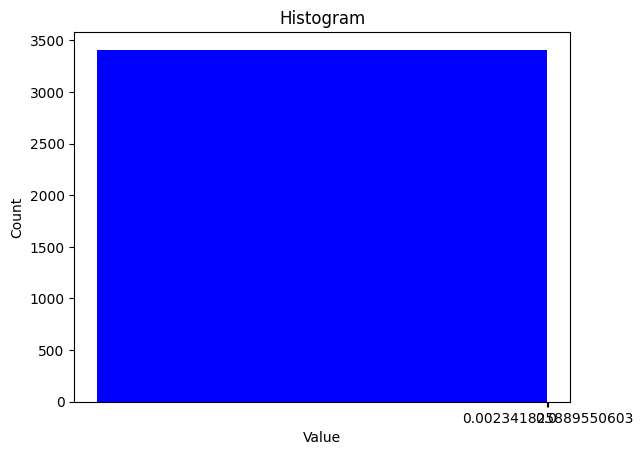

In [ ]:
# Degree centrality -- mean and stdev
dc = nx.degree_centrality(KG)
degrees = []
for k,v in dc.items():
    degrees.append(v)

print("DEGREE CENTRALITY")
print("=================")
print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
histogram(dc)
print()

# PageRank -- mean and stdev
pc = nx.pagerank(KG)
degrees = []
for k,v in pc.items():
    degrees.append(v)

print("PAGERANK")
print("======================")
print("The mean network pagerank is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(pc, key=pc.get), max(pc.values())))
print("The minimum node is {}, with value {}".format(min(pc, key=pc.get), min(pc.values())))
histogram(pc)
print()

# Betweenness centrality -- mean and stdev
bc = nx.betweenness_centrality(KG)
degrees = []
for k,v in bc.items():
    degrees.append(v)
print("BETWEENNESS CENTRALITY")
print("======================")
print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
histogram(bc)
print()